# Laboratorio 3 - Parte 1 

### Modelos de mezclas de funciones Gausianas y k-means

### 2019-II

#### Profesor: Julián D. Arias Londoño
#### julian.ariasl@udea.edu.co


## Guía del laboratorio

En este archivo va a encontrar tanto celdas de código cómo celdas de texto con las instrucciones para desarrollar el laboratorio.

Lea atentamente las instrucciones entregadas en las celdas de texto correspondientes y proceda con la solución de las preguntas planteadas.

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

#### Primer integrante: Santiago Alexis Sanchez Zuleta
#### Segundo integrante: Raúl Andrés Gómez Ramírez

In [0]:
#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("always") 

%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy import stats


## Ejercicio 1: Contextualización del problema

A continuación se leen los datos de un problema de clasificación. El problema corresponde a la clasificación de dígitos escritos a mano. Usaremos únicamente 4 de las 10 clases disponibles. Los datos fueron preprocesados para reducir el número de características. La técnica usada será analizada más adelante en el curso.

In [16]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits(n_class=4)

#--------- preprocesamiento--------------------
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)

#---------- Datos a usar ----------------------
X = data
Y = digits.target
X[39]

array([-0.02787119, -1.51679169,  1.11201902, -0.2447385 , -0.92782853,
       -1.294045  , -0.04657012, -0.93681082,  0.5098759 ,  0.1583091 ,
       -0.66487017, -1.01471061,  0.61352643,  0.52353671, -1.68252615,
       -0.42618529, -0.06480147,  0.5932617 ,  0.40174077, -0.6848559 ,
       -1.21433495,  0.75889299, -0.72895209,  1.20992568, -1.71369924,
        0.80138066, -0.41391133, -1.75796594, -1.89300962, -2.4537101 ,
       -0.97189737,  0.16458404, -0.94797496, -0.3904581 , -2.58826101,
        1.37596992, -1.30230876, -0.45680446, -0.09364962])

Un vistazo a la base de datos

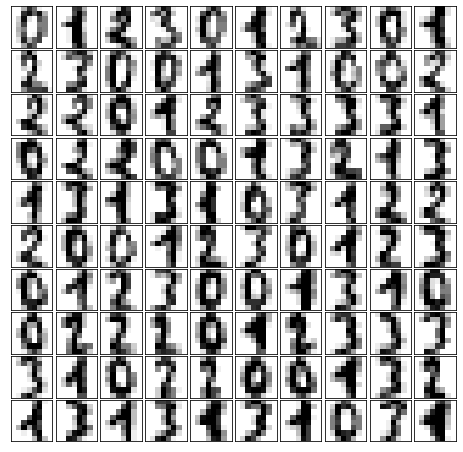

In [3]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Responda:

1.1 ¿Cuántas muestras por clase tiene la base de datos?:

In [4]:
C=np.unique(Y)
Class=X[Y==0],X[Y==1],X[Y==2],X[Y==3]
print('Muestras de la clases : ')
print('  0 ,  1 ,  2 ,  3  ')
len(Class[0]),len(Class[1]),len(Class[2]),len(Class[3]) #Muestras por clase

Muestras de la clases : 
  0 ,  1 ,  2 ,  3  


(178, 182, 177, 183)

1.2 ¿Cuántas características tiene cada muestra?


La muestra contiene 39 caracteristicas para cada clase

In [5]:
X.shape[1]

39

1.2 Teniendo en cuenta el tipo de problema y el número de muestras por clase, ¿qué metodología de validación debería usar?¿Porqué?:

Ya que las clases no estan desbalanceadas, una validación cruzada que toma k  subconjuntos divididos de manera aleatoria uno para validación y el resto para pruebas es una metodologia muy precisa ya que hace una evaluacion con combinaciones de datos de entrenamiento y prueba.

## Ejercicio 2: Completar el código

En la siguiente celda defina una función que tome como entradas una matriz $X$ y una matriz $Y$, entrene un modelo GMM  (Modelo de mezclas gaussianas) por cada clase y retorne el listado de modelos para cada clase. Debe consultar todo lo relacionado con la creación, entrenamiento y uso en predicción de este modelo usando la librería scikit-learn. Consultar aquí: http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html


Adicionalmente construya una función que use los modelos entrenados en la función anterior para hacer la clasificación de un conjunto nuevo de muestras.



In [0]:
def GMMClassifierTrain(X,Y,M,tipo):
    
    #X: Matriz con las características
    #Y: Matriz con las clases
    #M: Número de componentes
    #tipo: Tipo de matriz de covarianza
      
    Classes=np.unique(Y)
    GMMs=[] 
    tipo=tipo
    for clas in Classes:
      Xtrain= X[Y==clas,:]
      gaussian=GaussianMixture(n_components=M, covariance_type=tipo)
      gaussian.fit(Xtrain)
      GMMs.append(gaussian)
    
    return GMMs #Debe retornar un objeto que contenga todos los modelos entrenados


def GMMClassfierVal(GMMs,Xtest):
    
    nClasses=len(GMMs)
    values=Xtest.shape[0]
    probability=np.zeros((values, nClasses))

    for p in range(nClasses):
        probability[:, p] = np.exp(GMMs[p].score_samples(Xtest))   
    Yest = np.argmax(probability, axis=1)
    return Yest #Debe retornar un vector con las clases predichas para cada una de las muestras en Xtest, de acuerdo con los modelos almacenados en GMMs

## Ejercicio 3: Entrenamiento

En la siguiente celda se define una simulación para entrenar y validar un modelo usando los datos previamente cargados de lo digitos. Complete el código para usar como modelo de predicción un GMM.

Asegure que:


                                - Matriz de covarianza: diagonal 
                                - Numero de componentes: 3
                                - Eficiencia en validacion: 0.9555	
                                - Intervalo de confianza: 0.02297


In [0]:
import math
import numpy as np
from numpy import random
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
import numpy.matlib



#Validamos el modelo
def mainGMM(cov_index = 'Esférica',num_components=3):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        #(X,Y,M,tipo)
        gmms = GMMClassifierTrain(Xtrain,Ytrain,num_components,cov_index)



        #Validación
        Ytrain_pred = GMMClassfierVal(gmms,Xtrain);
        Yest = GMMClassfierVal(gmms,Xtest);

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1
        
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    return (np.std(EficienciaVal),np.mean(EficienciaVal))

   

In [18]:
epa=mainGMM('diag',3)


Eficiencia durante el entrenamiento = 0.9981481481481481+-0.002268046058132564
Eficiencia durante la validación = 0.9597222222222223+-0.007216878364870297


## Ejercicio 4: Resultados

Una vez completado el código realice los experimentos necesarios para llenar la siguiente tabla:

In [9]:
!pip install qgrid

In [10]:
import pandas as pd
import qgrid
randn = np.random.randn
df_types = pd.DataFrame({
    'Matriz de covarianza' : pd.Series(['full','full','full','full','full','full','diag','diag','diag','diag','diag','diag','spherical','spherical','spherical','spherical','spherical','spherical','tied','tied','tied','tied','tied','tied']),
    'Numero de componentes' : pd.Series([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])})
df_types["Eficiencia en validacion"] = ""
df_types["Intervalo de confianza"] = ""
df_types.set_index(['Matriz de covarianza','Numero de componentes'], inplace=True)
#df_types["Eficiencia en validacion"][8] = "0.9555"
#df_types["Intervalo de confianza"][8] = "0.02297"
#df_types.sort_index(inplace=True)
r=0
for prueba in df_types.index:
  #print(prueba[0])
  #print(prueba[1])
  
  gaussiana=mainGMM(prueba[0],prueba[1])  
  df_types["Eficiencia en validacion"][prueba] =  gaussiana[1]
  df_types["Intervalo de confianza"][prueba] = gaussiana[0]
  r=r+1
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

/usr/local/lib/python3.6/dist-packages/ipywidgets/widgets/widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qgrid/grid.py:573: DeprecationWarning: metadata {'sync': True} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  _df_json = Unicode('', sync=True)


Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9833333333333334+-0.014163943093313296
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9527777777777778+-0.03480545579483796
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9041666666666667+-0.010668257983150846
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.7013888888888888+-0.07771574907520991
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.41944444444444445+-0.155580355166005
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.2777777777777778+-0.025760051376376953
Eficiencia durante el entrenamiento = 0.987037037037037+-0.003928371006591917
Eficiencia durante la validación = 0.9263888888888889+-0.009918650595198423
Eficiencia durante el entrenamiento = 0.9976851851851851+-0.002018008770157708
Eficiencia durante la validación 

/usr/local/lib/python3.6/dist-packages/qgrid/grid.py:827: DeprecationWarning: QgridWidget._df_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _df_changed(self):


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Ejecute la siguiente instrucción para dejar guardados en el notebook los resultados de las pruebas.


In [11]:
qgrid_widget.get_changed_df()

Eficiencia en validacion Intervalo de confianza
Matriz de covarianza Numero de componentes                                                
full                 1                                     0.983333              0.0141639
                     2                                     0.952778              0.0348055
                     3                                     0.904167              0.0106683
                     4                                     0.701389              0.0777157
                     5                                     0.419444                0.15558
                     6                                     0.277778              0.0257601
diag                 1                                     0.926389             0.00991865
                     2                                     0.944444              0.0171234
                     3                                     0.959722             0.00721688
                     4                                     0.965278             0.00991865
                     5                                     0.955556              0.0288675
                     6                                     0.977778              0.0196419
spherical            1                                     0.884722              0.0158966
                     2                                     0.861111              0.0117851
                     3                                     0.869444              0.0177865
                     4                                     0.855556              0.0251538
                     5                                     0.855556              0.0340207
                     6                                       0.8875              0.0373454
tied                 1                                     0.983333              0.0141639
                     2                                     0.983333              0.0141639
                     3                                     0.983333              0.0141639
                     4                                     0.983333              0.0141639
                     5                                     0.983333              0.0124226
                     6                                     0.983333              0.0141639

Responda

4.1 La tabla incluye un tipo de matriz de covarianza no visto en clase, Atada, ¿En qué consiste este tipo de matriz según la documentación en scikit-learn?:

Según la documentación de scikit-learn todos los componentes comparten la misma matrix de covarianza en la matriz tied o atada.

4.2  ¿Qué método se utilizó para la incialización de los parámetros del modelo GMM?:

Se utiliza el metodo k-means donde cada media se toma de forma aleatoria y va cambiando de manera que se va ajustando a la media de los datos mas cercanos.

4.3 ¿El algoritmo EM presentó problemas de convergencia o colapso para alguna de las combinaciones de parámetros?

Con las combinaciones de los parametros no se presentaron problemas de convergencia y/o colapso.

## Ejercicio 5

En la siguiente celda, utilice las muestras de la base de datos iris incluidos en la variable Xclustering. 
Lleve a cabo el agrupamiento de los datos usando el algoritmo k-means y el modelo GMM.

Consultar todo lo relacionado al llamado del método KMeans de la librería scikit-learn en el siguiente enlace: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. 


Realice el agrupamiento para 2 y 3 grupos y grafique los resultados del agrupamiento en cada caso (use colores para los puntos de acuerdo con el grupo asignado por el algoritmo de agrupamiento). Para el caso del GMM use una matriz de covarianza completa y una matriz diagonal. El resultado de este punto son 6 gráficas.

Text(0.5, 1.0, 'Datos para agrupar')

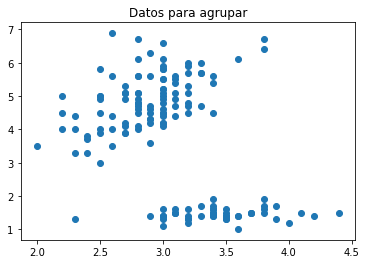

In [12]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 
data = load_iris()
X=data.data
Xclustering = X[:,1:3]
plt.scatter(Xclustering[:,0],Xclustering[:,1])
plt.title("Datos para agrupar")
#plt.show

##K-means

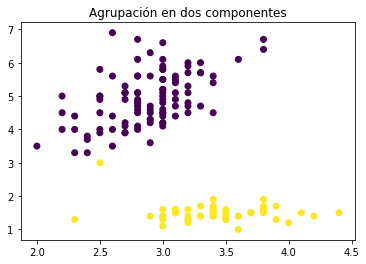

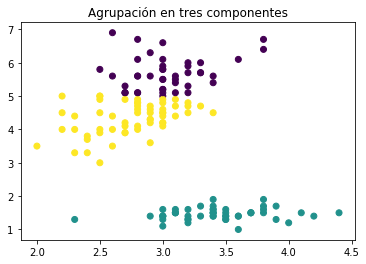

In [13]:
for means in [2, 3]:
    kmean = KMeans(n_clusters = means, init = 'random')
    means= kmean.fit_predict(Xclustering)
    if len(np.unique(means)) ==2:
      plt.title("Agrupación en dos componentes")
    else:
      plt.title("Agrupación en tres componentes")
    plt.scatter(Xclustering[:, 0], Xclustering[:, 1], c=means)
    plt.show()


##GMM

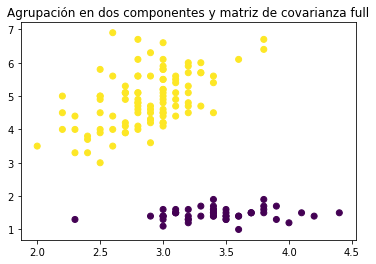

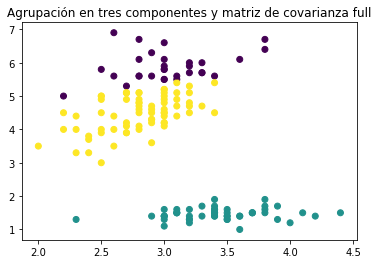

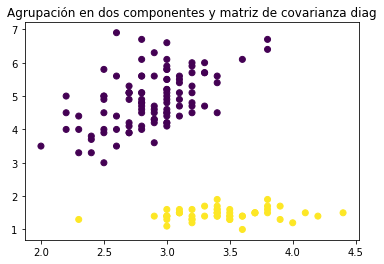

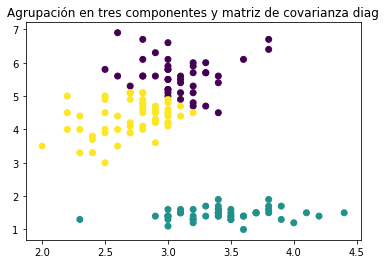

In [14]:

for matriz in ['full', 'diag']:
    for component in [2, 3]:
        gaussianMixes = GaussianMixture(n_components=component, covariance_type=matriz).fit(Xclustering)
        etiquetas = gaussianMixes.predict(Xclustering)
        if len(np.unique(etiquetas)) ==2:
          plt.title("Agrupación en dos componentes y matriz de covarianza " + matriz)
        else:
          plt.title("Agrupación en tres componentes y matriz de covarianza " + matriz)
        plt.scatter(Xclustering[:, 0], Xclustering[:, 1], c=etiquetas)
        plt.show()